In [866]:
import sys
import os
import networkx as nx
from sympy import *
from bond_graph import *
# from bond_graph_nodes import *
from scipy import *
import time
import matplotlib.pyplot as plt
%reload_ext autoreload
%autoreload 2


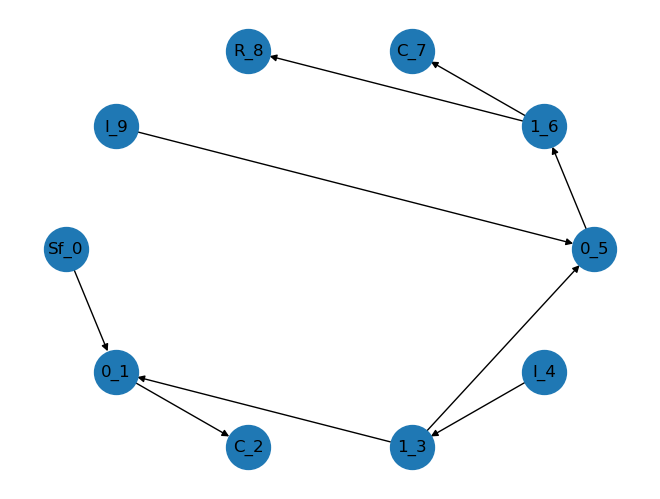

In [867]:
t_span = [0, 10]
time_array = np.linspace(t_span[0], t_span[1], 500)

m_wheel = 28.58
m_body = 288.9
# m_wheel = 28.58
# m_body = 1

Cnom = 1861.0
Knom = 19660.0

Copt = 1576.855
Kopt = 8098.479

Ktire = 155900.0

Cmin = 500.0
Cmax = 4500.0
Kmin = 5000.0
Kmax = 50000.0

G = BondGraph(max_nodes=20, max_states=4, time_array=time_array)
G.add_element(FlowSource())
G.add_element(ZeroJunction())
G.add_bond(0, 1, 1)
G.add_element(Capacitance(capacitance=1.0/155900.0)) # Tire stiffness
G.add_bond(1, 2, 1)
G.add_element(OneJunction())
G.add_bond(3, 1, -1)
G.add_element(Inertance(inertance=m_wheel)) # Wheel mass
G.add_bond(4, 3, -1)
G.add_element(ZeroJunction())
G.add_bond(3, 5, 1)
G.add_element(OneJunction())
G.add_bond(5, 6, 1)
G.add_element(Capacitance(capacitance=1.0/Kopt)) # Suspension spring
G.add_bond(6, 7, 1)
G.add_element(Resistance(resistance=Copt)) # Suspension damping
G.add_bond(6, 8, 1)
# G.add_element(OneJunction())
# G.add_bond(9, 5, -1)
G.add_element(Inertance(inertance=m_body)) # Body mass
G.add_bond(9, 5, -1)


# G.add_bond(1, 4, 1)

# Draw the bond graph with labels
labels = nx.get_node_attributes(G.flow_causal_graph, 'element_label')
nx.draw_shell(G.flow_causal_graph, labels=labels, with_labels=True, node_size=1000)

In [868]:
print(1.0/Cmin)
print(1.0/Cmax)



0.002
0.00022222222222222223


In [869]:
G.update_state_space_matrix(verbose=True)


Bond Graph Variables: 
State Derivatives:  [q_dot_2, p_dot_4, q_dot_7, p_dot_9]
States:  [q_2, p_4, q_7, p_9]
Bonds:  [e_0:1, f_0:1, e_1:2, f_1:2, e_3:1, f_3:1, e_3:5, f_3:5, e_4:3, f_4:3, e_5:6, f_5:6, e_6:7, f_6:7, e_6:8, f_6:8, e_9:5, f_9:5]

Constitutive Laws: 
[Eq(q_dot_2, f_1:2), Eq(p_dot_4, e_4:3), Eq(q_dot_7, f_6:7), Eq(p_dot_9, e_9:5), Eq(Sf_0, f_0:1), Eq(f_1:2, f_0:1 - f_3:1), Eq(e_1:2, e_0:1), Eq(e_1:2, e_3:1), Eq(e_1:2, 155900.0*q_2), Eq(-e_4:3, -e_3:1 + e_3:5), Eq(f_4:3, f_3:1), Eq(f_4:3, f_3:5), Eq(f_4:3, 0.0349895031490553*p_4), Eq(f_5:6, f_3:5 - f_9:5), Eq(e_5:6, e_3:5), Eq(e_5:6, e_9:5), Eq(e_5:6, e_6:7 + e_6:8), Eq(f_5:6, f_6:7), Eq(f_5:6, f_6:8), Eq(e_6:7, 8098.479*q_7), Eq(e_6:8, 1576.855*f_6:8), Eq(f_9:5, 0.00346140533056421*p_9)]

Matrix Formulation (Ax = b): 
A (22, 22): Matrix([[1, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

### Simulate Dynamics

In [870]:
def speed_bump_excitation(t, L, H, v):
    if t <= L/v:
        return -(H/2)*(np.cos(2*np.pi*v*t/L)-1)
        # return (np.pi*H*v/L)*(np.sin(2*np.pi*v*t/L))
        # return 0.0
    else:
        return 0.0


In [871]:
H = 0.075
L = 0.5
KPH_to_MPS = 1.0/3.6
v = 10 * KPH_to_MPS

t_span = [0, 3.0]
t = np.linspace(t_span[0], t_span[1], 1000)
# print(t)



### Speed Bump Forcing Function

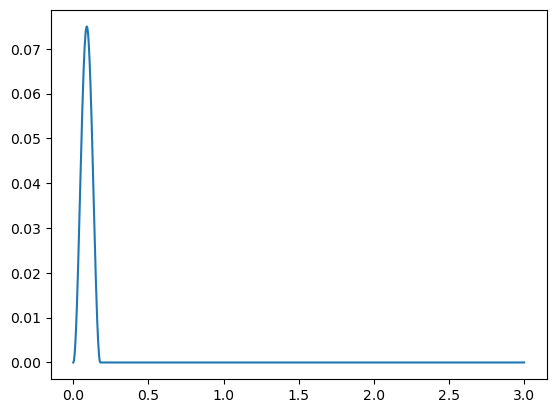

In [872]:
u = list(speed_bump_excitation(t_i, L, H, v) for t_i in t)
plt.plot(t,u)

### Solve ODE

In [873]:

# x0 = np.zeros(len(G.get_energy_storage_elements())) # Initial conditions
x0 = np.array([0.0, 0.0, 0, 0])
# print(len(np.array([0, 0])))
# u = lambda t: [0]
# G.dynamics(x0 , 1, u)

## Generate a forcing input at 5 hertz
u = lambda t: speed_bump_excitation(t, L, H, v)
# u = lambda t: 0

def quarter_car_dynamics(z, t, u):
    xw = z[0]
    xw_dot = z[1]
    xb = z[2]
    xb_dot = z[3]

    # # Params
    # m_wheel = 28.58
    # m_body = 288.9
    # # m_wheel = 28.58
    # # m_body = 1

    # Cnom = 1861
    # Knom = 19660

    # Copt = 1576.855
    # Kopt = 8098.479

    # Ktire = 155900.0

    # Cmin = 500
    # Cmax = 4500
    # Kmin = 5000
    # Kmax = 50000

    # xw_ddot = (1.0/m_wheel)*(-Copt*(xw_dot - xb_dot) - Kopt*(xw - xb) - Ktire*xw + Ktire*u(t))
    # xb_ddot = (1.0/m_body)*(-Copt*(xb_dot - xw_dot) - Kopt*(xb - xw))
    xw_ddot = (1.0/m_wheel)*(-Cnom*(xw_dot - xb_dot) - Knom*(xw - xb) - Ktire*xw + Ktire*u(t))
    xb_ddot = (1.0/m_body)*(-Cnom*(xb_dot - xw_dot) - Knom*(xb - xw))
    
    
    
    return [xw_dot, xw_ddot, xb_dot, xb_ddot]



# y = integrate.odeint(G.dynamics, x0, t, args=(u,))
y = integrate.odeint(quarter_car_dynamics, np.array(x0), t, args=(u,))







### Plots

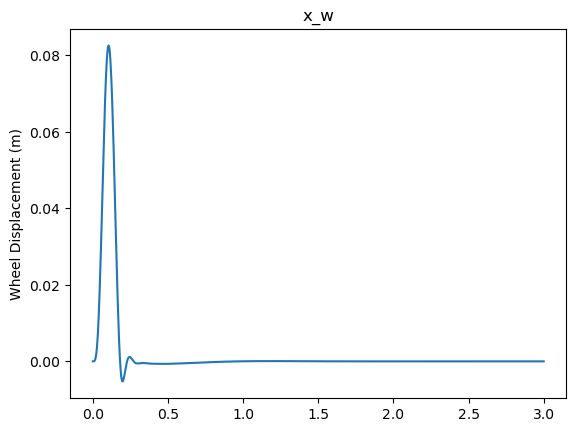

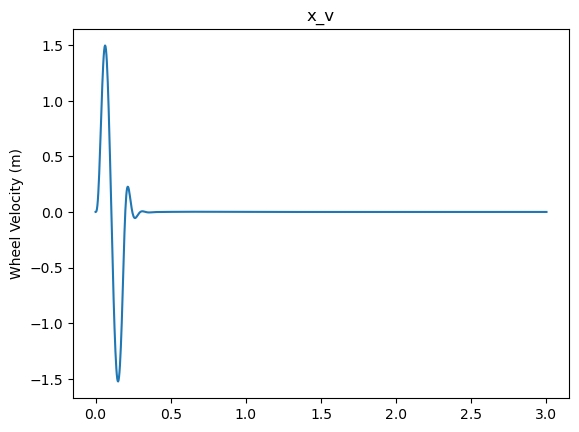

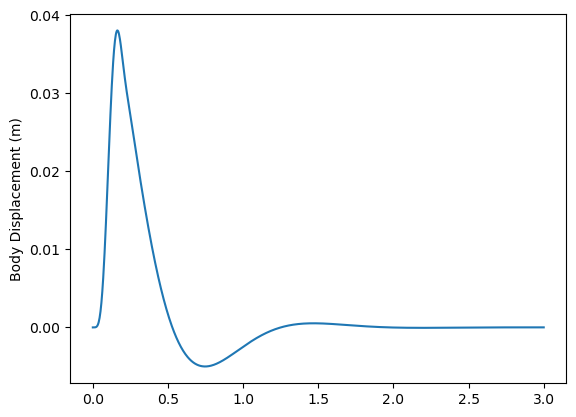

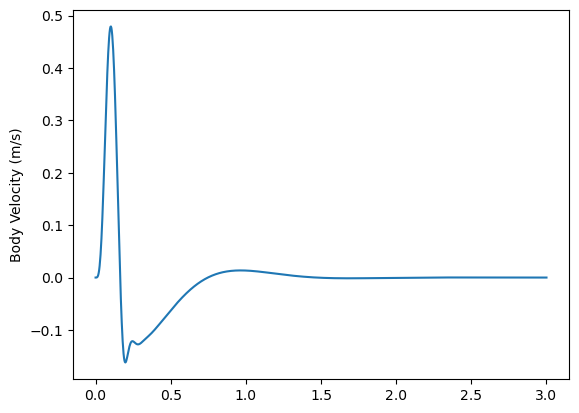

In [874]:

dt = t[1] - t[0]

xw = y[:, 0]
# vw = y[:, 1]/m_wheel
vw = y[:, 1]
xb = y[:, 2]
# vb = y[:, 3]/m_body
vb = y[:, 3]

# plt.plot(t, xw)
# # plt.plot(t, np.gradient(xb, t[1] - t[0]))
# plt.show()

plt.plot(t, xw, label="x_w")
plt.title("x_w")
plt.ylabel("Wheel Displacement (m)")
plt.show()
plt.plot(t, vw)
plt.title("x_v")
plt.ylabel("Wheel Velocity (m)")
plt.show()
plt.plot(t, xb)
plt.ylabel("Body Displacement (m)")
plt.show()
plt.plot(t, vb)
plt.ylabel("Body Velocity (m/s)")
plt.show()


### Cost Function Computation

In [875]:
## J1: Peak accel of vehicle body
ab = np.gradient(vb, dt)
J1 = np.linalg.norm(ab, np.inf)
print("J1: ", J1)
u = np.array([speed_bump_excitation(t_i, L, H, v) for t_i in t])

## J2: Peak dynamic load
# k_tire = 155900.0
J2 = np.linalg.norm(Ktire*(y[:,0] - u), np.inf)
print("J2: ", J2)

## J3: Suspension working space peak val
J3 = max(xb - xw)
print("J3: ", J3)

## J4: Settling time
crossing_times = [t[i] for i in range(len(xb)) if abs(xb[i]) > 0.0001]
last_crossing_time = crossing_times[-1] if crossing_times else None
# print(last_crossing_time)
J4 = last_crossing_time
print("J4: ", J4)

## Weights
w1 = 35
w2 = 35
w3 = 50
w4 = 50

J = [J1, J2, J3, J4]
w = [w1, w2, w3, w4]

# print("J:", J)

# J_lower = min(J1, J2, J3)
# J_upper = max(J1, J2, J3)
J_lower = [3.18, 1719, 0.044, 0.08]
J_upper = [18.75, 5499, 0.08, 3.0]


# J_overall = J_lower + J_upper
J_overall = 0

for i in range(len(J)):
    J_overall += abs(w[i] * (J[i] - J_lower[i])/(J_upper[i] - J_lower[i]))
    print(w[i] * (J[i] - J_lower[i])/(J_upper[i] - J_lower[i]))
    # J_overall += w[i] * (J[i] - J_lower[i])/(J_upper[i] - )
    

print("J Overall: ", J_overall)


J1:  10.691515378351133
J2:  3556.502186635866
J3:  0.04000885742874824
J4:  1.84984984984985
16.885230458721235
17.013909135517277
-5.543253571182996
30.305648113867292
J Overall:  69.7480412792888
